## Import libraries

In [1]:
! pip install "/kaggle/input/autocorrect/autocorrect-2.6.1.tar"
! pip install "/kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl"

Processing /kaggle/input/autocorrect/autocorrect-2.6.1.tar
  Preparing metadata (setup.py) ... - \ done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622383 sha256=cb1bef283d8e22f827665e2bd4da7206a02d17148066291ebca63e7591267aa2
  Stored in directory: /root/.cache/pip/wheels/db/69/42/0fb0421d2fe70d195a04665edc760cfe5fd341d7bb8d8e0aaa
Successfully built autocorrect
Processing /kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl


In [2]:
import gc
import string
import pickle
import joblib
import operator
import lightgbm as lgb
from textblob import TextBlob

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from autocorrect import Speller
from spellchecker import SpellChecker

import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model

tqdm.pandas()
np.random.seed(2022)
tf.random.set_seed(2022)
plt.style.use('fivethirtyeight')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Hyperparameters

In [3]:
class Config:
    
    vocab_size = 25000
    sequence_length = 1024
    embed_dim = 300
    folds = 4
    verbose = 0
    epochs = 75
    batch_size = 32
    lr_start = 6e-3
    lr_end = 1e-6
    weight_decay = 1e-3

config = Config()

## Load source datasets

In [4]:
prompts_train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv")
prompts_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv")
summaries_train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv")
summaries_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv")

## Target data distribution

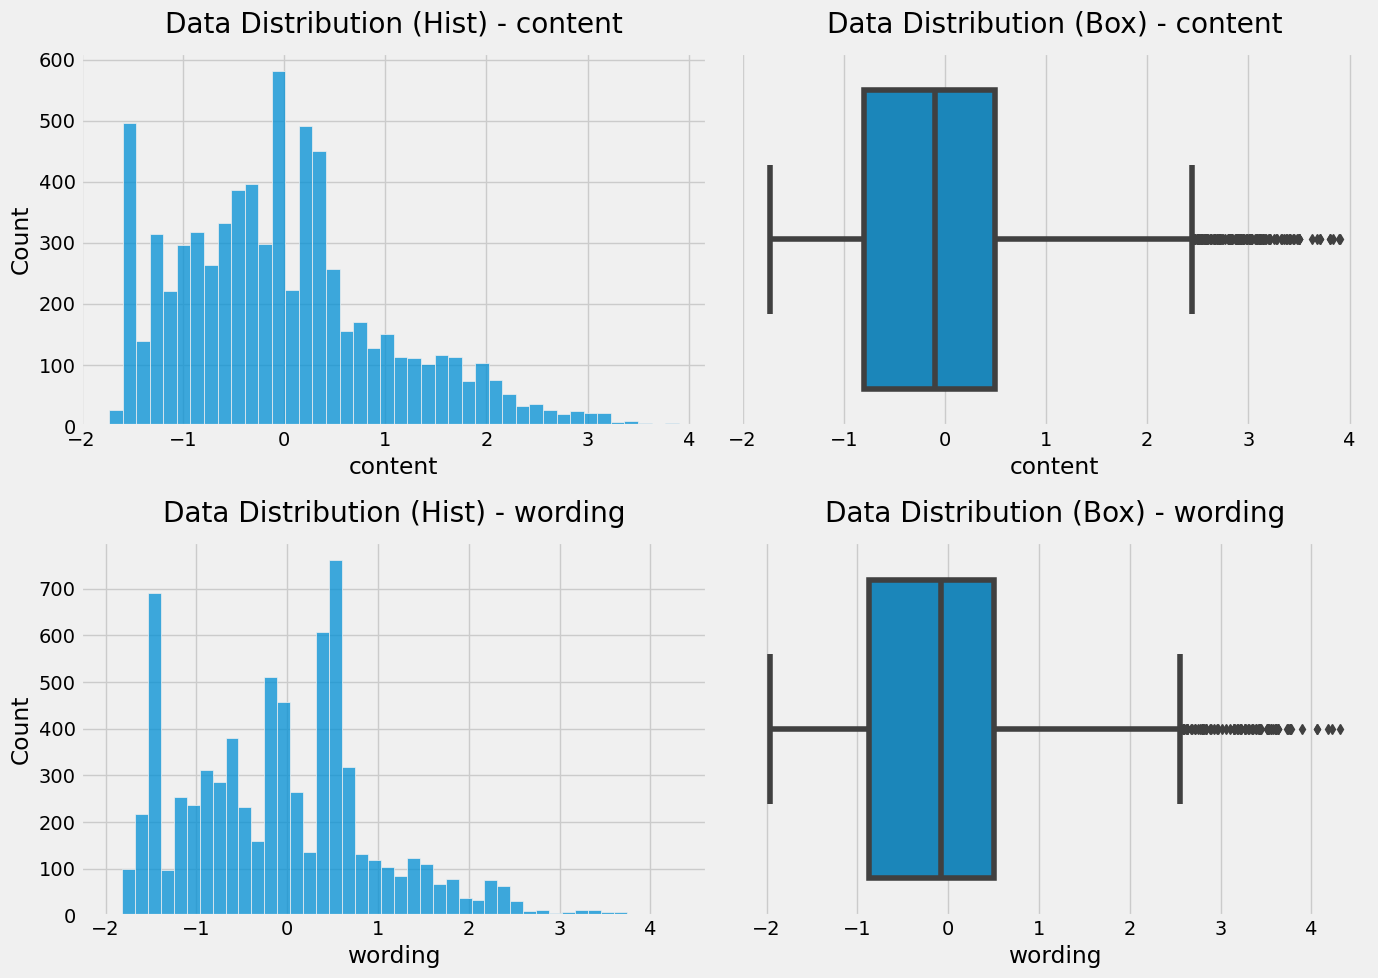

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(x='content', data=summaries_train, ax=ax[0][0])
sns.boxplot(x='content', data=summaries_train, ax=ax[0][1])
sns.histplot(x='wording', data=summaries_train, ax=ax[1][0])
sns.boxplot(x='wording', data=summaries_train, ax=ax[1][1])
ax[0][0].set_title(f"Data Distribution (Hist) - content", pad=15)
ax[0][1].set_title(f"Data Distribution (Box) - content", pad=15)
ax[1][0].set_title(f"Data Distribution (Hist) - wording", pad=15)
ax[1][1].set_title(f"Data Distribution (Box) - wording", pad=15)
fig.tight_layout();

## Load word embeddings

In [6]:
with open("../input/nlp-word-embeddings/Glove_Embeddings.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
glove_embeddings_index = processed_data['glove_embeddings_index']
print('Word vectors found: {}'.format(len(glove_embeddings_index)))

Word vectors found: 2196017


In [7]:
with open("../input/nlp-word-embeddings/Para_Embeddings.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
para_embeddings_index = processed_data['para_embeddings_index']
print('Word vectors found: {}'.format(len(para_embeddings_index)))

Word vectors found: 1703755


In [8]:
with open("../input/nlp-word-embeddings/FastText_Embeddings.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
fasttext_embeddings_index = processed_data['fasttext_embeddings_index']
print('Word vectors found: {}'.format(len(fasttext_embeddings_index)))

Word vectors found: 1000000


In [9]:
del processed_data
gc.collect()

0

## Text preprocessing

In [10]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [11]:
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        if word in embeddings_index:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        elif word.capitalize() in embeddings_index:
            known_words[word] = embeddings_index[word.capitalize()]
            nb_known_words += vocab[word]
        elif word.lower() in embeddings_index:
            known_words[word] = embeddings_index[word.lower()]
            nb_known_words += vocab[word]
        elif word.upper() in embeddings_index:
            known_words[word] = embeddings_index[word.upper()]
            nb_known_words += vocab[word]
        else:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [12]:
def vocab_check_coverage(df, col='text'):
    vocab = build_vocab(df[col])
    print("Glove : ")
    oov_glove = check_coverage(vocab, glove_embeddings_index)
    oov_glove = {"oov_rate": len(oov_glove) / len(vocab), 'oov_words': oov_glove}
    
    print("Paragram : ")
    oov_paragram = check_coverage(vocab, para_embeddings_index)
    oov_paragram = {"oov_rate": len(oov_paragram) / len(vocab), 'oov_words': oov_paragram}
    
    print("FastText : ")
    oov_fasttext = check_coverage(vocab, fasttext_embeddings_index)
    oov_fasttext = {"oov_rate": len(oov_fasttext) / len(vocab), 'oov_words': oov_fasttext}
    
    return oov_glove, oov_paragram, oov_fasttext

In [13]:
misspell_mapping = {
    'studentdesigned': 'student designed',
    'teacherdesigned': 'teacher designed',
    'genericname': 'generic name',
    'winnertakeall': 'winner take all',
    'studentname': 'student name',
    'driveless': 'driverless',
    'teachername': 'teacher name',
    'propername': 'proper name',
    'bestlaid': 'best laid',
    'genericschool': 'generic school',
    'schoolname': 'school name',
    'winnertakesall': 'winner take all',
    'elctoral': 'electoral',
    'eletoral': 'electoral',
    'genericcity': 'generic city',
    'elctors': 'electoral',
    'venuse': 'venue',
    'blimplike': 'blimp like',
    'selfdriving': 'self driving',
    'electorals': 'electoral',
    'nearrecord': 'near record',
    'egyptianstyle': 'egyptian style',
    'oddnumbered': 'odd numbered',
    'carintensive': 'car intensive',
    'elecoral': 'electoral',
    'oction': 'auction',
    'electroal': 'electoral',
    'evennumbered': 'even numbered',
    'mesalandforms': 'mesa landforms',
    'electoralvote': 'electoral vote',
    'relativename': 'relative name',
    '22euro': 'twenty two euro',
    'ellectoral': 'electoral',
    'thirtyplus': 'thirty plus',
    'collegewon': 'college won',
    'hisher': 'higher',
    'teacherbased': 'teacher based',
    'computeranimated': 'computer animated',
    'canadidate': 'candidate',
    'studentbased': 'student based',
    'gorethanks': 'gore thanks',
    'clouddraped': 'cloud draped',
    'edgarsnyder': 'edgar snyder',
    'emotionrecognition': 'emotion recognition',
    'landfrom': 'land form',
    'fivedays': 'five days',
    'electoal': 'electoral',
    'lanform': 'land form',
    'electral': 'electoral',
    'presidentbut': 'president but',
    'teacherassigned': 'teacher assigned',
    'beacuas': 'because',
    'positionestimating': 'position estimating',
    'selfeducation': 'self education',
    'diverless': 'driverless',
    'computerdriven': 'computer driven',
    'outofcontrol': 'out of control',
    'faultthe': 'fault the',
    'unfairoutdated': 'unfair outdated',
    'aviods': 'avoid',
    'momdad': 'mom dad',
    'statesbig': 'states big',
    'presidentswing': 'president swing',
    'inconclusion': 'in conclusion',
    'handsonlearning': 'hands on learning',
    'electroral': 'electoral',
    'carowner': 'car owner',
    'elecotral': 'electoral',
    'studentassigned': 'student assigned',
    'collegefive': 'college five',
    'presidant': 'president',
    'unfairoutdatedand': 'unfair outdated and',
    'nixonjimmy': 'nixon jimmy',
    'canadates': 'candidate',
    'tabletennis': 'table tennis',
    'himher': 'him her',
    'studentsummerpacketdesigners': 'student summer packet designers',
    'studentdesign': 'student designed',
    'limting': 'limiting',
    'electrol': 'electoral',
    'campaignto': 'campaign to',
    'presendent': 'president',
    'thezebra': 'the zebra',
    'landformation': 'land formation',
    'eyetoeye': 'eye to eye',
    'selfreliance': 'self reliance',
    'studentdriven': 'student driven',
    'winnertake': 'winner take',
    'alliens': 'aliens',
    '2000but': '2000 but',
    'electionto': 'election to',
    'candidatesas': 'candidates as',
    'electers': 'electoral',
    'winnertakes': 'winner takes',
    'isfeet': 'is feet',
    'incar': 'incur',
    'wellconstructed': 'well constructed',
    'craftsmenwomen': 'crafts men women',
    'freelunch': 'free lunch',
    'twothousandrevolutions': 'two thousand revolutions',
    'ushistoryorg': 'us history org',
    'pharohs': 'pharaohs',
    'whitehot': 'white hot',
    'vizers': 'visors',
    'mrjones': 'mr jones',
    'aminute': 'a minute',
    'spoiledmeat': 'spoiled meat',
    'farmersgave': 'farmers gave',
    'spolied': 'spoiled',
    'tradgey': 'tragedy',
    'pyrimid': 'pyramid',
    'pyrimad': 'pyramid',
    'egyptiansfrom': 'egyptians from',
    'harvestthats': 'harvest that',
    'expierment': 'experiment',
    'jestthat': 'jest that',
    'twothousandrevolutionsaminute': 'two thousand revolutions a minute',
    'expirament': 'experiment',
    'nonspoiled': 'non spoiled',
    'egyptains': 'egyptians',
    'tragedys': 'tragedy',
    'pyrmaid': 'pyramid',
    'expirment': 'experiment',
    'whiteit': 'grade there',
    'gradethere': 'tragedy',
    'goverement': 'government',
    'godsthe': 'gods the',
    'paraoh': 'pharaoh',
    'classesupper': 'classes upper',
    'pharoes': 'pharaohs',
    'noblespriests': 'noble priests',
    'farmersslaves': 'farmers slaves',
    'harvestâ€”thatâ€™s': 'harvest that',
    'tradedy': 'tragedy',
    'paraohs': 'pharaohs',
    'paragrapgh': 'paragraph',
    'expieriment': 'experiment',
    'tragdey': 'tragedy',
    'pyramaid': 'pyramid',
    'pyrmid': 'pyramid',
    'prists': 'priests',
    'pharoas': 'pharaohs',
    'priets': 'priests',
    'pharoph': 'pharaohs',
    'pharaoah': 'pharaohs',
    'pharahos': 'pharaohs',
    'pharaohthe': 'pharaohs'
}

In [14]:
def decontraction(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"he's", "he is", phrase)
    phrase = re.sub(r"there's", "there is", phrase)
    phrase = re.sub(r"We're", "We are", phrase)
    phrase = re.sub(r"That's", "That is", phrase)
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"they're", "they are", phrase)
    phrase = re.sub(r"Can't", "Cannot", phrase)
    phrase = re.sub(r"wasn't", "was not", phrase)
    phrase = re.sub(r"don\x89Ûªt", "do not", phrase)
    phrase = re.sub(r"donãât", "do not", phrase)
    phrase = re.sub(r"aren't", "are not", phrase)
    phrase = re.sub(r"isn't", "is not", phrase)
    phrase = re.sub(r"What's", "What is", phrase)
    phrase = re.sub(r"haven't", "have not", phrase)
    phrase = re.sub(r"hasn't", "has not", phrase)
    phrase = re.sub(r"There's", "There is", phrase)
    phrase = re.sub(r"He's", "He is", phrase)
    phrase = re.sub(r"It's", "It is", phrase)
    phrase = re.sub(r"You're", "You are", phrase)
    phrase = re.sub(r"I'M", "I am", phrase)
    phrase = re.sub(r"shouldn't", "should not", phrase)
    phrase = re.sub(r"wouldn't", "would not", phrase)
    phrase = re.sub(r"i'm", "I am", phrase)
    phrase = re.sub(r"I\x89Ûªm", "I am", phrase)
    phrase = re.sub(r"I'm", "I am", phrase)
    phrase = re.sub(r"Isn't", "is not", phrase)
    phrase = re.sub(r"Here's", "Here is", phrase)
    phrase = re.sub(r"you've", "you have", phrase)
    phrase = re.sub(r"you\x89Ûªve", "you have", phrase)
    phrase = re.sub(r"we're", "we are", phrase)
    phrase = re.sub(r"what's", "what is", phrase)
    phrase = re.sub(r"couldn't", "could not", phrase)
    phrase = re.sub(r"we've", "we have", phrase)
    phrase = re.sub(r"it\x89Ûªs", "it is", phrase)
    phrase = re.sub(r"doesn\x89Ûªt", "does not", phrase)
    phrase = re.sub(r"It\x89Ûªs", "It is", phrase)
    phrase = re.sub(r"Here\x89Ûªs", "Here is", phrase)
    phrase = re.sub(r"who's", "who is", phrase)
    phrase = re.sub(r"I\x89Ûªve", "I have", phrase)
    phrase = re.sub(r"y'all", "you all", phrase)
    phrase = re.sub(r"can\x89Ûªt", "cannot", phrase)
    phrase = re.sub(r"would've", "would have", phrase)
    phrase = re.sub(r"it'll", "it will", phrase)
    phrase = re.sub(r"we'll", "we will", phrase)
    phrase = re.sub(r"wouldn\x89Ûªt", "would not", phrase)
    phrase = re.sub(r"We've", "We have", phrase)
    phrase = re.sub(r"he'll", "he will", phrase)
    phrase = re.sub(r"Y'all", "You all", phrase)
    phrase = re.sub(r"Weren't", "Were not", phrase)
    phrase = re.sub(r"Didn't", "Did not", phrase)
    phrase = re.sub(r"they'll", "they will", phrase)
    phrase = re.sub(r"they'd", "they would", phrase)
    phrase = re.sub(r"DON'T", "DO NOT", phrase)
    phrase = re.sub(r"That\x89Ûªs", "That is", phrase)
    phrase = re.sub(r"they've", "they have", phrase)
    phrase = re.sub(r"i'd", "I would", phrase)
    phrase = re.sub(r"should've", "should have", phrase)
    phrase = re.sub(r"You\x89Ûªre", "You are", phrase)
    phrase = re.sub(r"where's", "where is", phrase)
    phrase = re.sub(r"Don\x89Ûªt", "Do not", phrase)
    phrase = re.sub(r"we'd", "we would", phrase)
    phrase = re.sub(r"i'll", "I will", phrase)
    phrase = re.sub(r"weren't", "were not", phrase)
    phrase = re.sub(r"They're", "They are", phrase)
    phrase = re.sub(r"Can\x89Ûªt", "Cannot", phrase)
    phrase = re.sub(r"you\x89Ûªll", "you will", phrase)
    phrase = re.sub(r"I\x89Ûªd", "I would", phrase)
    phrase = re.sub(r"let's", "let us", phrase)
    phrase = re.sub(r"it's", "it is", phrase)
    phrase = re.sub(r"can't", "cannot", phrase)
    phrase = re.sub(r"don't", "do not", phrase)
    phrase = re.sub(r"you're", "you are", phrase)
    phrase = re.sub(r"i've", "I have", phrase)
    phrase = re.sub(r"that's", "that is", phrase)
    phrase = re.sub(r"i'll", "I will", phrase)
    phrase = re.sub(r"doesn't", "does not",phrase)
    phrase = re.sub(r"i'd", "I would", phrase)
    phrase = re.sub(r"didn't", "did not", phrase)
    phrase = re.sub(r"ain't", "am not", phrase)
    phrase = re.sub(r"you'll", "you will", phrase)
    phrase = re.sub(r"I've", "I have", phrase)
    phrase = re.sub(r"Don't", "do not", phrase)
    phrase = re.sub(r"I'll", "I will", phrase)
    phrase = re.sub(r"I'd", "I would", phrase)
    phrase = re.sub(r"Let's", "Let us", phrase)
    phrase = re.sub(r"you'd", "You would", phrase)
    phrase = re.sub(r"It's", "It is", phrase)
    phrase = re.sub(r"Ain't", "am not", phrase)
    phrase = re.sub(r"Haven't", "Have not", phrase)
    phrase = re.sub(r"Could've", "Could have", phrase)
    phrase = re.sub(r"youve", "you have", phrase)  
    phrase = re.sub(r"donå«t", "do not", phrase)
    return phrase

In [15]:
def clean_text(text):
    text = decontraction(text)
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    return text

In [16]:
def remove_punctuations(text):
    for punctuation in list(string.punctuation):
        text = text.replace(punctuation, '')
    return text

In [17]:
def clean_number(text):
    text = re.sub(r'(\d+)([a-zA-Z])', '\g<1> \g<2>', text)
    text = re.sub(r'(\d+) (th|st|nd|rd) ', '\g<1>\g<2> ', text)
    text = re.sub(r'(\d+),(\d+)', '\g<1>\g<2>', text)
    return text

In [18]:
def clean_misspell(text):
    for bad_word in misspell_mapping:
        if bad_word in text:
            text = text.replace(bad_word, misspell_mapping[bad_word])
    return text

In [19]:
def pos_count(sent):
    nn_count = 0   #Noun
    pr_count = 0   #Pronoun
    vb_count = 0   #Verb
    jj_count = 0   #Adjective
    uh_count = 0   #Interjection
    cd_count = 0   #Numerics
    
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)

    for token in sent:
        if token[1] in ['NN','NNP','NNS']:
            nn_count += 1

        if token[1] in ['PRP','PRP$']:
            pr_count += 1

        if token[1] in ['VB','VBD','VBG','VBN','VBP','VBZ']:
            vb_count += 1

        if token[1] in ['JJ','JJR','JJS']:
            jj_count += 1

        if token[1] in ['UH']:
            uh_count += 1

        if token[1] in ['CD']:
            cd_count += 1
    
    return pd.Series([nn_count, pr_count, vb_count, jj_count, uh_count, cd_count])

In [20]:
speller = Speller(lang='en')
spellchecker = SpellChecker()
stop_words = set(stopwords.words('english'))


def add_spelling_dictionary(tokens):
    spellchecker.word_frequency.load_words(tokens)
    speller.nlp_data.update({token:1000 for token in tokens})
    

def spelling(text):
    wordlist = text.split()
    amount_miss = len(list(spellchecker.unknown(wordlist)))
    return amount_miss


def word_overlap_count(row):
    def check_is_stop_word(word):
        return word in stop_words
    
    prompt_words = row['prompt_tokens']
    summary_words = row['summary_tokens']
    
    if stop_words:
        prompt_words = list(filter(check_is_stop_word, prompt_words))
        summary_words = list(filter(check_is_stop_word, summary_words))
    
    return len(set(prompt_words).intersection(set(summary_words)))


def ngrams(token, n):
    ngrams = zip(*[token[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]


def ngram_co_occurrence(row, n):
    original_tokens = row['prompt_tokens']
    summary_tokens = row['summary_tokens']

    original_ngrams = set(ngrams(original_tokens, n))
    summary_ngrams = set(ngrams(summary_tokens, n))

    common_ngrams = original_ngrams.intersection(summary_ngrams)
    return len(common_ngrams)


def quotes_count(row):
        summary = row['text']
        text = row['prompt_text']
        quotes_from_summary = re.findall(r'"([^"]*)"', summary)
        if len(quotes_from_summary)>0:
            return [quote in text for quote in quotes_from_summary].count(True)
        else:
            return 0

In [21]:
def text_preprocess(prompts, summaries):
    prompts["prompt_length"] = prompts["prompt_text"].progress_apply(lambda x: len(word_tokenize(x)))
    prompts["prompt_tokens"] = prompts["prompt_text"].progress_apply(lambda x: word_tokenize(x))
    summaries["summary_length"] = summaries["text"].progress_apply(lambda x: len(word_tokenize(x)))
    summaries["summary_tokens"] = summaries["text"].progress_apply(lambda x: word_tokenize(x))
    prompts["prompt_tokens"].progress_apply(lambda x: add_spelling_dictionary(x))
    #summaries["fixed_summary_text"] = summaries["text"].progress_apply(lambda x: speller(x))
    summaries["splling_err_num"] = summaries["text"].progress_apply(spelling)
    
    df = summaries.merge(prompts, how="left", on="prompt_id")
    df['length_ratio'] = df['summary_length'] / df['prompt_length']
    df['word_overlap_count'] = df.progress_apply(word_overlap_count, axis=1)
    df['bigram_overlap_count'] = df.progress_apply(ngram_co_occurrence, args=(2,), axis=1)
    df['bigram_overlap_ratio'] = df['bigram_overlap_count'] / (df['summary_length'] - 1)
    df['trigram_overlap_count'] = df.progress_apply(ngram_co_occurrence, args=(3,), axis=1)
    df['trigram_overlap_ratio'] = df['trigram_overlap_count'] / (df['summary_length'] - 2)
    df['quotes_count'] = df.progress_apply(quotes_count, axis=1)
    return df.drop(columns=["summary_tokens", "prompt_tokens"])

In [22]:
train = text_preprocess(prompts_train, summaries_train)

train.drop([
    'student_id',
    'prompt_question',
    'prompt_title',
    'prompt_text'
], axis=1, inplace=True)

print(f"train: {train.shape}")
train.head()

100%|██████████| 7165/7165 [00:00<00:00, 44168.02it/s]


train: (7165, 14)


,prompt_id,text,content,wording,summary_length,splling_err_num,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,bigram_overlap_ratio,trigram_overlap_count,trigram_overlap_ratio,quotes_count
0,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,64,5,660,0.096970,14,4,0.063492,0,0.000000,0
1,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,54,2,1076,0.050186,18,22,0.415094,10,0.192308,0
2,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,269,32,625,0.430400,22,52,0.194030,23,0.086142,2
3,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,28,5,625,0.044800,6,6,0.222222,5,0.192308,0
4,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,232,29,660,0.351515,23,27,0.116883,5,0.021739,4


In [23]:
train["num_words"] = train["text"].progress_apply(lambda x: len(str(x).split()))
train["num_unique_words"] = train["text"].progress_apply(lambda x: len(set(str(x).split())))
train["num_chars"] = train["text"].progress_apply(lambda x: len(str(x)))
train["num_stopwords"] = train["text"].progress_apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')]))
train["num_punctuations"] =train['text'].progress_apply(lambda x: len([c for c in str(x) if c in list(string.punctuation)]))
train["num_words_upper"] = train["text"].progress_apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
train["num_words_title"] = train["text"].progress_apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
train["mean_word_len"] = train["text"].progress_apply(lambda x: np.mean([len(w) for w in str(x).split()]))
train["num_paragraphs"] = train["text"].progress_apply(lambda x: len(x.split('\n')))
train["num_sentences"] = train["text"].progress_apply(lambda x: len(str(x).split('.')))
train["polarity"] = train['text'].progress_apply(lambda x: TextBlob(x).sentiment[0])
train["subjectivity"] = train['text'].progress_apply(lambda x: TextBlob(x).sentiment[1])
train[['nn_count','pr_count','vb_count','jj_count','uh_count','cd_count']] = train['text'].progress_apply(pos_count)
train.head()

100%|██████████| 7165/7165 [00:40<00:00, 175.06it/s]


,prompt_id,text,content,wording,summary_length,splling_err_num,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,...,num_paragraphs,num_sentences,polarity,subjectivity,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count
0,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,64,5,660,0.096970,14,4,...,1,4,0.170455,0.334848,14,3,17,6,0,1
1,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,54,2,1076,0.050186,18,22,...,1,3,-0.700000,0.666667,9,5,8,2,0,0
2,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,269,32,625,0.430400,22,52,...,1,13,0.377778,0.483889,67,15,44,15,0,2
3,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,28,5,625,0.044800,6,6,...,1,5,0.000000,0.000000,8,0,6,3,0,1
4,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,232,29,660,0.351515,23,27,...,1,14,0.048203,0.355229,59,11,37,7,0,6


In [24]:
test = text_preprocess(prompts_test, summaries_test)

test.drop([
    'student_id',
    'prompt_question',
    'prompt_title',
    'prompt_text'
], axis=1, inplace=True)

print(f"test: {test.shape}")
test.head()

100%|██████████| 4/4 [00:00<00:00, 2912.21it/s]

test: (4, 12)


,prompt_id,text,summary_length,splling_err_num,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,bigram_overlap_ratio,trigram_overlap_count,trigram_overlap_ratio,quotes_count
0,abc123,Example text 1,3,0,3,1.0,0,0,0.0,0,0.0,0
1,def789,Example text 2,3,0,3,1.0,0,0,0.0,0,0.0,0
2,abc123,Example text 3,3,0,3,1.0,0,0,0.0,0,0.0,0
3,def789,Example text 4,3,0,3,1.0,0,0,0.0,0,0.0,0


In [25]:
test["num_words"] = test["text"].progress_apply(lambda x: len(str(x).split()))
test["num_unique_words"] = test["text"].progress_apply(lambda x: len(set(str(x).split())))
test["num_chars"] = test["text"].progress_apply(lambda x: len(str(x)))
test["num_stopwords"] = test["text"].progress_apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')]))
test["num_punctuations"] =test['text'].progress_apply(lambda x: len([c for c in str(x) if c in list(string.punctuation)]))
test["num_words_upper"] = test["text"].progress_apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_title"] = test["text"].progress_apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["mean_word_len"] = test["text"].progress_apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["num_paragraphs"] = test["text"].progress_apply(lambda x: len(x.split('\n')))
test["num_sentences"] = test["text"].progress_apply(lambda x: len(str(x).split('.')))
test["polarity"] = test['text'].progress_apply(lambda x: TextBlob(x).sentiment[0])
test["subjectivity"] = test['text'].progress_apply(lambda x: TextBlob(x).sentiment[1])
test[['nn_count','pr_count','vb_count','jj_count','uh_count','cd_count']] = test['text'].progress_apply(pos_count)
test.head()

100%|██████████| 4/4 [00:00<00:00, 815.66it/s]


,prompt_id,text,summary_length,splling_err_num,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,bigram_overlap_ratio,trigram_overlap_count,...,num_paragraphs,num_sentences,polarity,subjectivity,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count
0,abc123,Example text 1,3,0,3,1.0,0,0,0.0,0,...,1,1,0.0,0.0,2,0,0,0,0,1
1,def789,Example text 2,3,0,3,1.0,0,0,0.0,0,...,1,1,0.0,0.0,2,0,0,0,0,1
2,abc123,Example text 3,3,0,3,1.0,0,0,0.0,0,...,1,1,0.0,0.0,2,0,0,0,0,1
3,def789,Example text 4,3,0,3,1.0,0,0,0.0,0,...,1,1,0.0,0.0,2,0,0,0,0,1


In [26]:
text_features = [
    'summary_length',
    'splling_err_num',
    'prompt_length',
    'length_ratio',
    'word_overlap_count',
    'bigram_overlap_count',
    'bigram_overlap_ratio',
    'trigram_overlap_count',
    'trigram_overlap_ratio',
    'quotes_count',
    "num_words",
    "num_unique_words",
    "num_chars",
    "num_stopwords",
    "num_punctuations",
    "num_words_upper",
    "num_words_title",
    "mean_word_len",
    "num_paragraphs",
    "num_sentences",
    "polarity",
    "subjectivity",
    'nn_count',
    'pr_count',
    'vb_count',
    'jj_count',
    'uh_count',
    'cd_count'
]

len(text_features)

28

In [27]:
scaler = StandardScaler().fit(train[text_features])
train[text_features] = scaler.transform(train[text_features])
test[text_features] = scaler.transform(test[text_features])
train[text_features].head()

,summary_length,splling_err_num,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,bigram_overlap_ratio,trigram_overlap_count,trigram_overlap_ratio,quotes_count,...,num_paragraphs,num_sentences,polarity,subjectivity,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count
0,-0.319463,-0.507499,-0.624726,-0.178868,-0.165914,-0.773761,-1.211317,-0.648154,-0.887836,-0.416261,...,-0.046851,-0.276666,0.468771,-0.565728,-0.311755,-0.263633,0.307702,-0.040775,-0.059327,0.330000
1,-0.482817,-0.909174,1.591395,-0.712514,0.456644,-0.197961,0.443183,-0.327372,-0.082671,-0.416261,...,-0.046851,-0.538116,-4.059989,1.265356,-0.647249,0.269136,-0.553465,-0.876099,-0.059327,-0.584326
2,3.029279,3.107575,-0.811178,3.624452,1.079201,0.761707,-0.597058,0.089644,-0.527170,2.295114,...,-0.046851,2.076384,1.547422,0.256727,3.244487,2.932983,2.891202,1.838703,-0.059327,1.244325
3,-0.907535,-0.507499,-0.811178,-0.773949,-1.411029,-0.709783,-0.464396,-0.487763,-0.082671,-0.416261,...,-0.046851,-0.015216,-0.418062,-2.413533,-0.714348,-1.062788,-0.744835,-0.667268,-0.059327,0.330000
4,2.424872,2.705900,-0.624726,2.724641,1.234840,-0.038016,-0.960080,-0.487763,-0.796818,5.006489,...,-0.046851,2.337834,-0.167276,-0.453263,2.707696,1.867444,2.221405,0.168056,-0.059327,4.901629


In [28]:
joblib.dump(scaler, './standard_scaler.pkl')

['./standard_scaler.pkl']

In [29]:
train['text_clean'] = train['text'].progress_apply(clean_text)
train['text_clean'] = train['text_clean'].progress_apply(remove_punctuations)
train['text_clean'] = train['text_clean'].progress_apply(clean_number)
train['text_clean'] = train['text_clean'].progress_apply(clean_misspell)
train.head()

100%|██████████| 7165/7165 [00:00<00:00, 16859.76it/s]


,prompt_id,text,content,wording,summary_length,splling_err_num,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,...,num_sentences,polarity,subjectivity,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,text_clean
0,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,-0.319463,-0.507499,-0.624726,-0.178868,-0.165914,-0.773761,...,-0.276666,0.468771,-0.565728,-0.311755,-0.263633,0.307702,-0.040775,-0.059327,0.330000,the third wave was an experimentto see how peo...
1,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,-0.482817,-0.909174,1.591395,-0.712514,0.456644,-0.197961,...,-0.538116,-4.059989,1.265356,-0.647249,0.269136,-0.553465,-0.876099,-0.059327,-0.584326,they would rub it up with soda to make the sme...
2,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,3.029279,3.107575,-0.811178,3.624452,1.079201,0.761707,...,2.076384,1.547422,0.256727,3.244487,2.932983,2.891202,1.838703,-0.059327,1.244325,in egypt there were many occupations and socia...
3,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,-0.907535,-0.507499,-0.811178,-0.773949,-1.411029,-0.709783,...,-0.015216,-0.418062,-2.413533,-0.714348,-1.062788,-0.744835,-0.667268,-0.059327,0.330000,the highest class was pharaohs these people we...
4,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,2.424872,2.705900,-0.624726,2.724641,1.234840,-0.038016,...,2.337834,-0.167276,-0.453263,2.707696,1.867444,2.221405,0.168056,-0.059327,4.901629,the third wave developed rapidly because the ...


In [30]:
test['text_clean'] = test['text'].progress_apply(clean_text)
test['text_clean'] = test['text_clean'].progress_apply(remove_punctuations)
test['text_clean'] = test['text_clean'].progress_apply(clean_number)
test['text_clean'] = test['text_clean'].progress_apply(clean_misspell)
test.head()

100%|██████████| 4/4 [00:00<00:00, 6058.94it/s]


,prompt_id,text,summary_length,splling_err_num,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,bigram_overlap_ratio,trigram_overlap_count,...,num_sentences,polarity,subjectivity,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,text_clean
0,abc123,Example text 1,-1.315918,-1.176957,-4.124705,10.121676,-2.344865,-0.901717,-1.510086,-0.648154,...,-1.061016,-0.418062,-2.413533,-1.116942,-1.062788,-1.318947,-1.293761,-0.059327,0.33,example text 1
1,def789,Example text 2,-1.315918,-1.176957,-4.124705,10.121676,-2.344865,-0.901717,-1.510086,-0.648154,...,-1.061016,-0.418062,-2.413533,-1.116942,-1.062788,-1.318947,-1.293761,-0.059327,0.33,example text 2
2,abc123,Example text 3,-1.315918,-1.176957,-4.124705,10.121676,-2.344865,-0.901717,-1.510086,-0.648154,...,-1.061016,-0.418062,-2.413533,-1.116942,-1.062788,-1.318947,-1.293761,-0.059327,0.33,example text 3
3,def789,Example text 4,-1.315918,-1.176957,-4.124705,10.121676,-2.344865,-0.901717,-1.510086,-0.648154,...,-1.061016,-0.418062,-2.413533,-1.116942,-1.062788,-1.318947,-1.293761,-0.059327,0.33,example text 4


In [31]:
oov_glove, oov_paragram, oov_fasttext = vocab_check_coverage(train, 'text_clean')

print("\n============================================\n")
print('glove oov rate:', oov_glove['oov_rate'])
print('paragram oov rate:', oov_paragram['oov_rate'])
print('fasttext oov rate:', oov_fasttext['oov_rate'])

Glove : 
Found embeddings for 69.43% of vocab
Found embeddings for  99.02% of all text
Paragram : 
Found embeddings for 69.98% of vocab
Found embeddings for  99.04% of all text
FastText : 
Found embeddings for 64.50% of vocab
Found embeddings for  98.82% of all text


glove oov rate: 0.30565653628035483
paragram oov rate: 0.3002035771411953
fasttext oov rate: 0.3550239930202123


In [32]:
del prompts_train, summaries_train
del prompts_test, summaries_test
gc.collect()

609

## Text Vectorization

In [33]:
vectorize_layer = layers.TextVectorization(
    standardize=None,
    max_tokens=config.vocab_size,
    output_mode='int',
    output_sequence_length=config.sequence_length
)

with tf.device("CPU"):
    vectorize_layer.adapt(train['text_clean'])

In [34]:
vocab = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))
num_tokens = len(vocab) + 2

## TF Embedding Matrix

In [35]:
hits = 0
misses = 0

glove_embedding_matrix = np.zeros((num_tokens, config.embed_dim))
for word, i in word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        glove_embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9448 words (4312 misses)


In [36]:
hits = 0
misses = 0

para_embedding_matrix = np.zeros((num_tokens, config.embed_dim))
for word, i in word_index.items():
    embedding_vector = para_embeddings_index.get(word)
    if embedding_vector is not None:
        para_embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9625 words (4135 misses)


In [37]:
hits = 0
misses = 0

fasttext_embedding_matrix = np.zeros((num_tokens, config.embed_dim))
for word, i in word_index.items():
    embedding_vector = fasttext_embeddings_index.get(word)
    if embedding_vector is not None:
        fasttext_embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 8712 words (5048 misses)


In [38]:
embedding_matrix = (glove_embedding_matrix * 0.5) + (para_embedding_matrix * 0.35) + (fasttext_embedding_matrix * 0.15)

In [39]:
del glove_embedding_matrix, para_embedding_matrix, fasttext_embedding_matrix
gc.collect()

720

## TF Model

In [40]:
text_features = [
    "num_words",
    "num_unique_words",
    "num_chars",
    "num_stopwords",
    "num_punctuations",
    "num_words_upper",
    "num_words_title",
    "mean_word_len",
    "num_paragraphs",
    "num_sentences",
    "polarity",
    "subjectivity",
    'nn_count',
    'pr_count',
    'vb_count',
    'jj_count',
    'uh_count',
    'cd_count'
]

In [41]:
def commonlit_model():
    
    text_input = layers.Input(shape=(1,), dtype=tf.string, name='Input-Text')
    text_vec = vectorize_layer(text_input)
    
    fet_input = layers.Input(shape=(len(text_features),), name='Input-Features')
    x0 = layers.Dense(units=32, activation="gelu")(fet_input)
    x1 = layers.Dense(units=64, activation="gelu")(x0)
    
    embed = layers.Embedding(num_tokens, config.embed_dim,
                             weights=[embedding_matrix],
                             trainable=False, name='Text-Embed')(text_vec)
    
    conv0 = layers.Conv1D(filters=128, kernel_size=7, strides=1, 
                          activation='gelu', padding='same')(embed)
    conv0 = layers.AveragePooling1D(pool_size=4, padding='same')(conv0)
    conv0 = layers.SpatialDropout1D(rate=0.25)(conv0)
    
    lstm0 = layers.Bidirectional(layers.LSTM(units=64, return_sequences=True))(conv0)
    lstm0 = layers.LayerNormalization(epsilon=1e-6)(lstm0)
    lstm1 = layers.AveragePooling1D(pool_size=4, padding='same')(lstm0)
    
    lstm1 = layers.Bidirectional(layers.LSTM(units=32, return_sequences=True))(lstm1)
    lstm1 = layers.LayerNormalization(epsilon=1e-6)(lstm1)
    
    concat = layers.Concatenate()([
        x1, 
        layers.GlobalAveragePooling1D()(lstm0),
        layers.GlobalAveragePooling1D()(lstm1)
    ])
    x = layers.Dropout(rate=0.35)(concat)
    
    x = layers.Dense(units=64, activation="gelu")(x)
    x = layers.Multiply()([x1, x])
    x = layers.Dropout(rate=0.2)(x)
    
    x = layers.Dense(units=16, activation="gelu")(x)
    x = layers.Dropout(rate=0.1)(x)
    
    x_output = layers.Dense(units=1, name='output')(x)

    model = Model(inputs=[text_input, fet_input], 
                  outputs=x_output, 
                  name='Commonlit_TF_Model')
    
    return model

In [42]:
model = commonlit_model()
model.summary()

Model: "Commonlit_TF_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input-Text (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 1024)        0           ['Input-Text[0][0]']             
 ization)                                                                                         
                                                                                                  
 Text-Embed (Embedding)         (None, 1024, 300)    4128600     ['text_vectorization[0][0]']     
                                                                                                  
 conv1d (Conv1D)                (None, 1024, 128)    268928      ['Text-Embed[0][

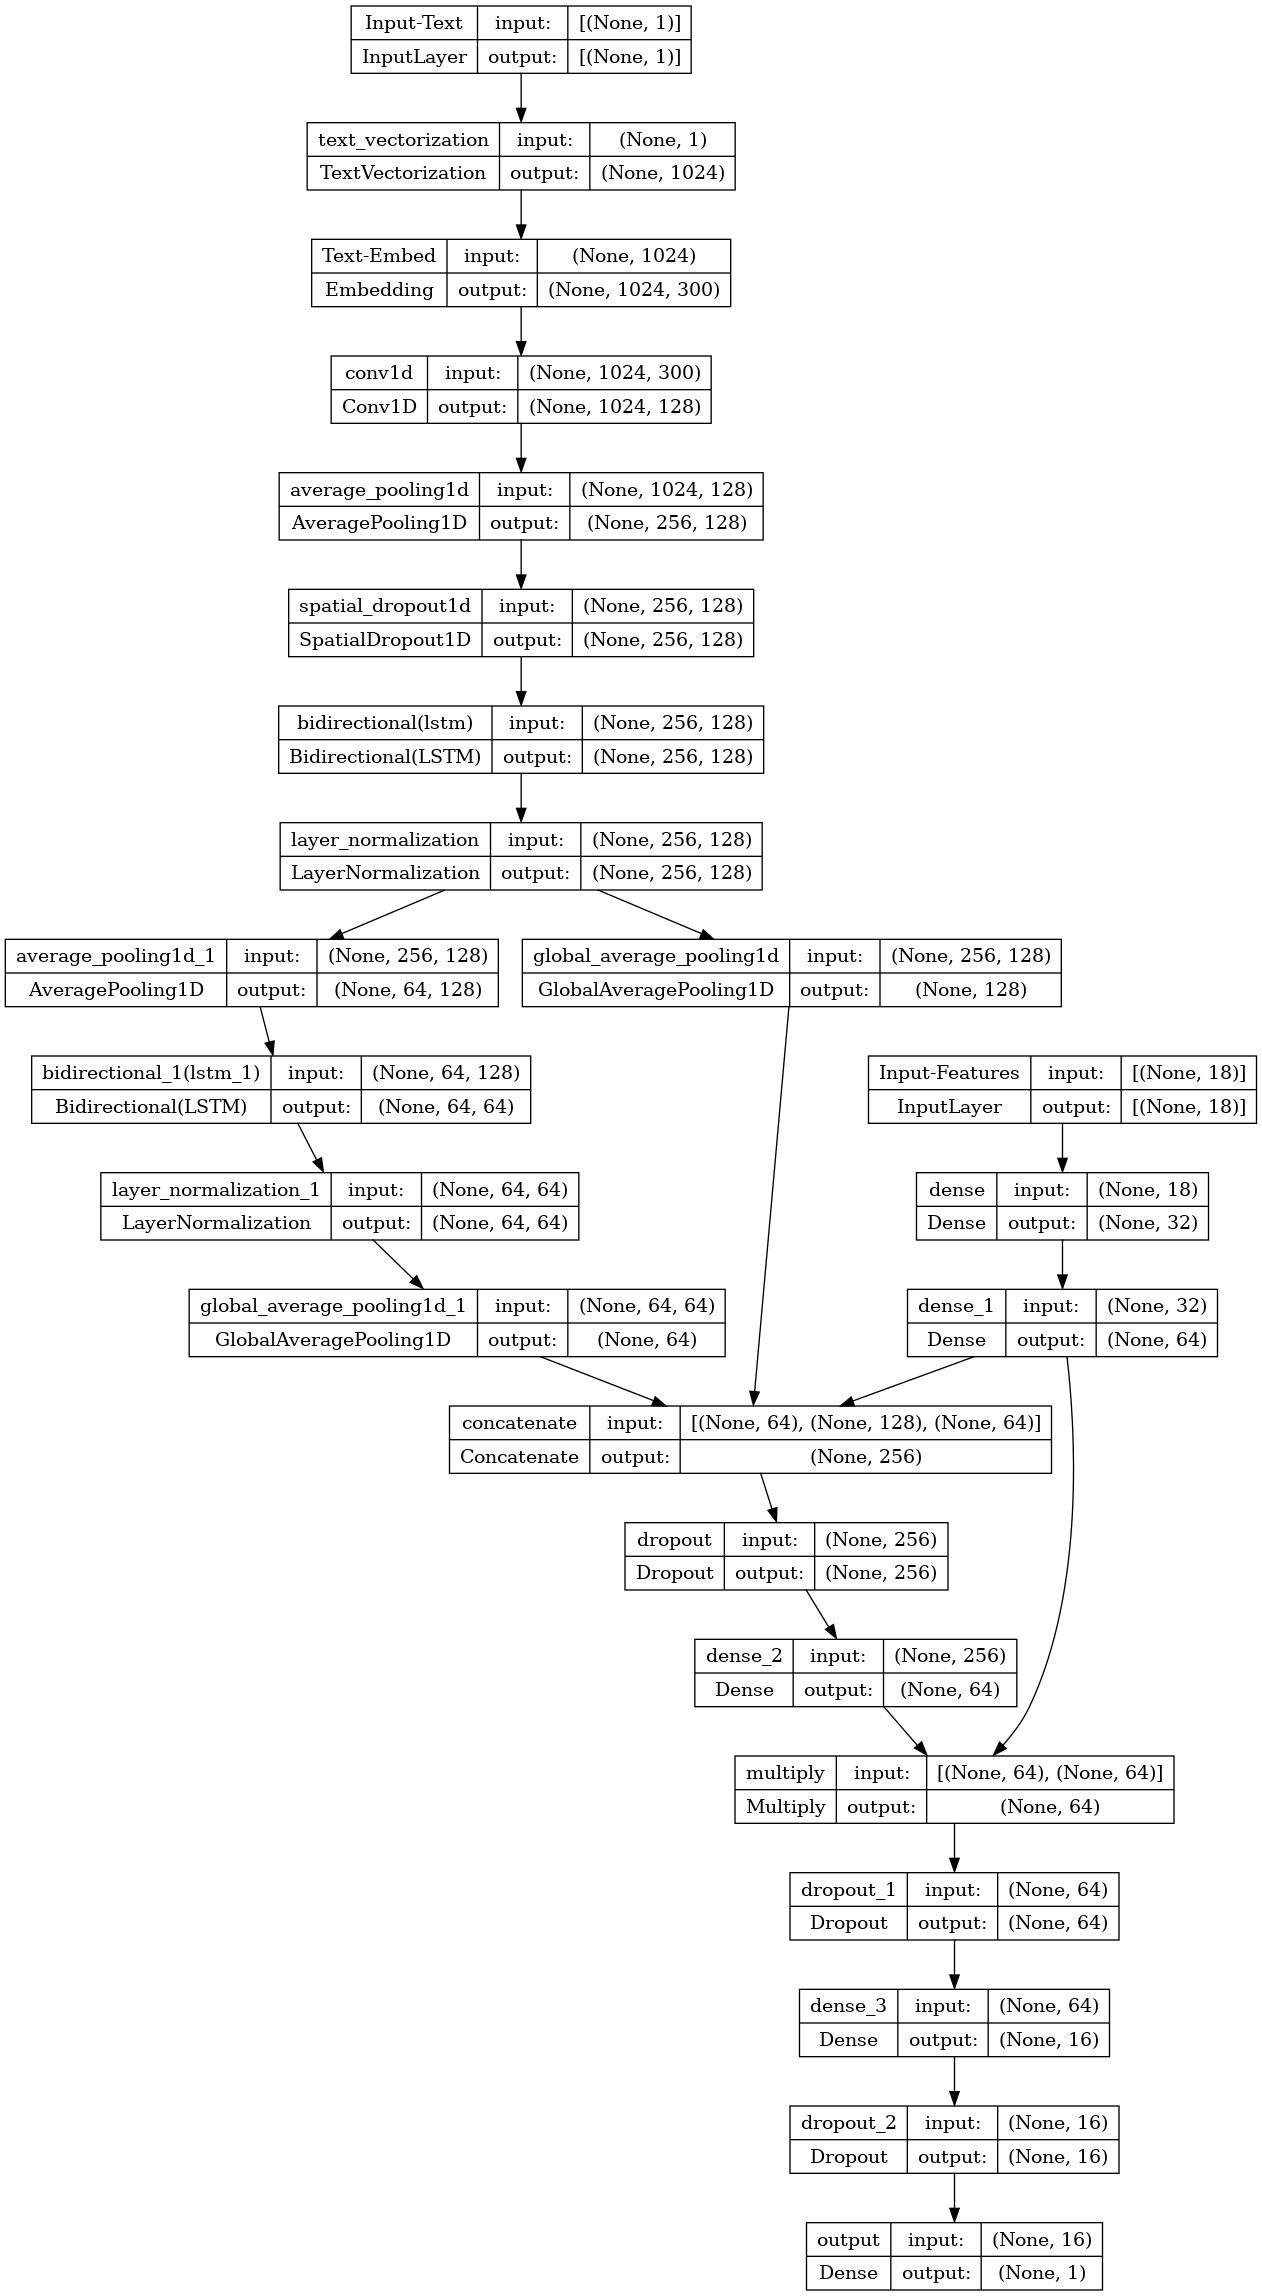

In [43]:
tf.keras.utils.plot_model(
    model, to_file='./Commonlit_TF_Model.png', 
    show_shapes=True, show_layer_names=True
)

## Training for Content

In [44]:
counter = 0
oof_score = 0
loss_values = {}

train_preds_content = np.zeros((train.shape[0], 1))
test_preds_content = []


kf = StratifiedKFold(n_splits=config.folds, shuffle=True, random_state=2022)

for fold, (train_idx, val_idx) in enumerate(kf.split(train, train['prompt_id'])):
    counter += 1
    
    train_text, val_text = train.iloc[train_idx]['text_clean'], \
                           train.iloc[val_idx]['text_clean']
    
    train_fet, val_fet = train.iloc[train_idx][text_features], \
                         train.iloc[val_idx][text_features]
    
    train_content_labels, val_content_labels = train.iloc[train_idx]['content'], \
                                               train.iloc[val_idx]['content']
    
    model = commonlit_model()
    
    model.compile(loss='mse', 
                  metrics=[
                      tf.keras.metrics.RootMeanSquaredError(name='rmse')
                  ], 
                  optimizer=optimizers.AdamW(learning_rate=config.lr_start, weight_decay=config.weight_decay))

    early = callbacks.EarlyStopping(monitor="val_rmse", mode="min", 
                                    restore_best_weights=True, 
                                    patience=7, verbose=config.verbose)

    reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_rmse", factor=0.5, 
                                            min_lr=config.lr_end, patience=3, 
                                            verbose=config.verbose, mode='min')

    chk_point = callbacks.ModelCheckpoint(f'./Commonlit_TF_Content_Model_{counter}C', 
                                          monitor='val_rmse', verbose=config.verbose, 
                                          save_best_only=True, mode='min',
                                          save_weights_only=True)

    history = model.fit(
        [train_text, train_fet], 
        train_content_labels, 
        batch_size=config.batch_size,
        epochs=config.epochs, 
        verbose=config.verbose, 
        callbacks=[reduce_lr, early, chk_point], 
        validation_data=(
            [val_text, val_fet], 
            val_content_labels
        )
    )

    loss_values["train_rmse_"+str(counter)] = history.history['rmse']
    loss_values["valid_rmse_"+str(counter)] = history.history['val_rmse']
    
    model.load_weights(f'./Commonlit_TF_Content_Model_{counter}C')

    y_pred = model.predict(
        [val_text, val_fet], 
        batch_size=config.batch_size, 
        verbose=config.verbose
    )
    
    train_preds_content[val_idx] += y_pred
    
    content_rmse_score = np.sqrt(mean_squared_error(val_content_labels, y_pred))
    oof_score += content_rmse_score
    print(f"Fold-{counter} | Content Score: {round(content_rmse_score,4)}")
    
    y_pred = model.predict(
        [test['text_clean'], test[text_features]], 
        batch_size=config.batch_size, 
        verbose=config.verbose
    )
    
    test_preds_content.append(y_pred)
    
    del model, y_pred
    del train_text, val_text
    del train_fet, val_fet
    del val_content_labels
    del train_content_labels
    gc.collect()


oof_score /= float(counter)
print(f"Aggregate OOF Score: {oof_score}")

Fold-1 | Content Score: 0.5111
Fold-2 | Content Score: 0.4753
Fold-3 | Content Score: 0.5001
Fold-4 | Content Score: 0.4786
Aggregate OOF Score: 0.49126799535710886


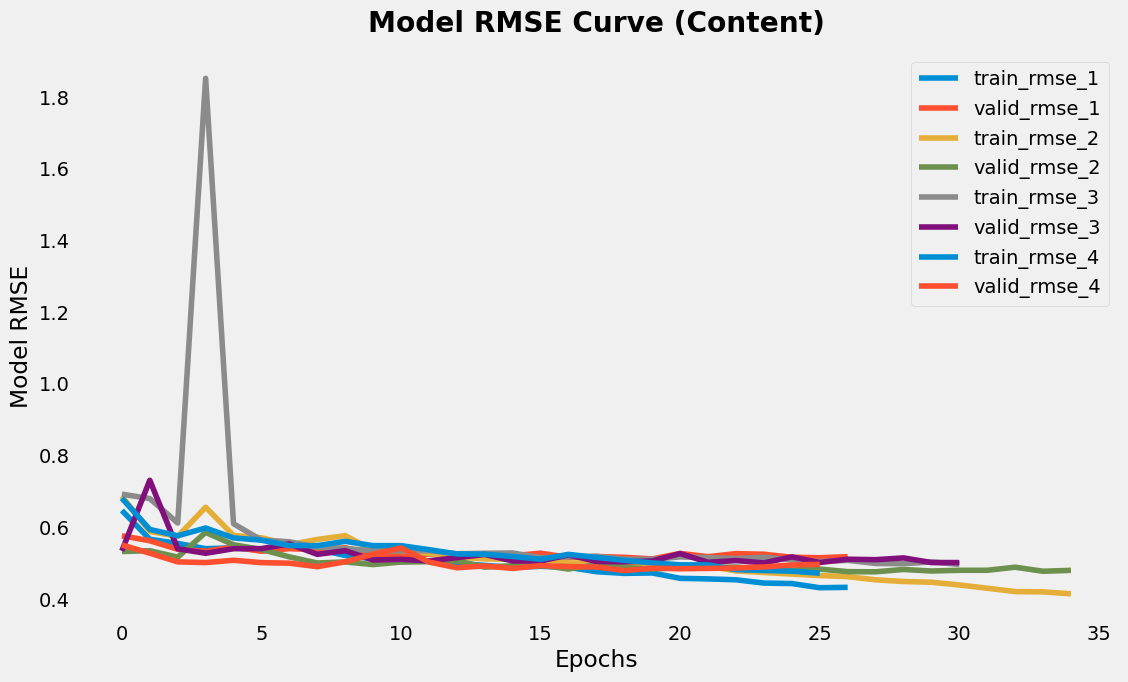

In [45]:
plt.figure(figsize=(12, 7))
plt.title("Model RMSE Curve (Content)", fontweight='bold', pad=15)

for i in range(config.folds):
    plt.plot(loss_values["train_rmse_"+str(i+1)], label='train_rmse_'+str(i+1))
    plt.plot(loss_values["valid_rmse_"+str(i+1)], label='valid_rmse_'+str(i+1))

plt.ylabel('Model RMSE')
plt.xlabel('Epochs')
plt.legend()
plt.grid();

## Training for Wording

In [46]:
counter = 0
oof_score = 0
loss_values = {}

train_preds_wording = np.zeros((train.shape[0], 1))
test_preds_wording = []


kf = StratifiedKFold(n_splits=config.folds, shuffle=True, random_state=2022)

for fold, (train_idx, val_idx) in enumerate(kf.split(train, train['prompt_id'])):
    counter += 1
    
    train_text, val_text = train.iloc[train_idx]['text_clean'], \
                           train.iloc[val_idx]['text_clean']
    
    train_fet, val_fet = train.iloc[train_idx][text_features], \
                         train.iloc[val_idx][text_features]
    
    train_wording_labels, val_wording_labels = train.iloc[train_idx]['wording'], \
                                               train.iloc[val_idx]['wording']
    
    model = commonlit_model()
    
    model.compile(loss='mse', 
                  metrics=[
                      tf.keras.metrics.RootMeanSquaredError(name='rmse')
                  ], 
                  optimizer=optimizers.AdamW(learning_rate=config.lr_start, weight_decay=config.weight_decay))

    early = callbacks.EarlyStopping(monitor="val_rmse", mode="min", 
                                    restore_best_weights=True, 
                                    patience=7, verbose=config.verbose)

    reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_rmse", factor=0.5, 
                                            min_lr=config.lr_end, patience=3, 
                                            verbose=config.verbose, mode='min')

    chk_point = callbacks.ModelCheckpoint(f'./Commonlit_TF_Wording_Model_{counter}C', 
                                          monitor='val_rmse', verbose=config.verbose, 
                                          save_best_only=True, mode='min',
                                          save_weights_only=True)

    history = model.fit(
        [train_text, train_fet], 
        train_wording_labels, 
        batch_size=config.batch_size,
        epochs=config.epochs, 
        verbose=config.verbose, 
        callbacks=[reduce_lr, early, chk_point], 
        validation_data=(
            [val_text, val_fet], 
            val_wording_labels
        )
    )

    loss_values["train_rmse_"+str(counter)] = history.history['rmse']
    loss_values["valid_rmse_"+str(counter)] = history.history['val_rmse']
    
    model.load_weights(f'./Commonlit_TF_Wording_Model_{counter}C')

    y_pred = model.predict(
        [val_text, val_fet], 
        batch_size=config.batch_size, 
        verbose=config.verbose
    )
    
    train_preds_wording[val_idx] += y_pred
    
    wording_rmse_score = np.sqrt(mean_squared_error(val_wording_labels, y_pred))
    oof_score += wording_rmse_score
    print(f"Fold-{counter} | Wording Score: {round(wording_rmse_score,4)}")
    
    y_pred = model.predict(
        [test['text_clean'], test[text_features]], 
        batch_size=config.batch_size, 
        verbose=config.verbose
    )
    
    test_preds_wording.append(y_pred)
    
    del model, y_pred
    del train_text, val_text
    del train_fet, val_fet
    del val_wording_labels
    del train_wording_labels
    gc.collect()


oof_score /= float(counter)
print(f"Aggregate OOF Score: {oof_score}")

Fold-1 | Wording Score: 0.686
Fold-2 | Wording Score: 0.6908
Fold-3 | Wording Score: 0.7063
Fold-4 | Wording Score: 0.661
Aggregate OOF Score: 0.6860214961781559


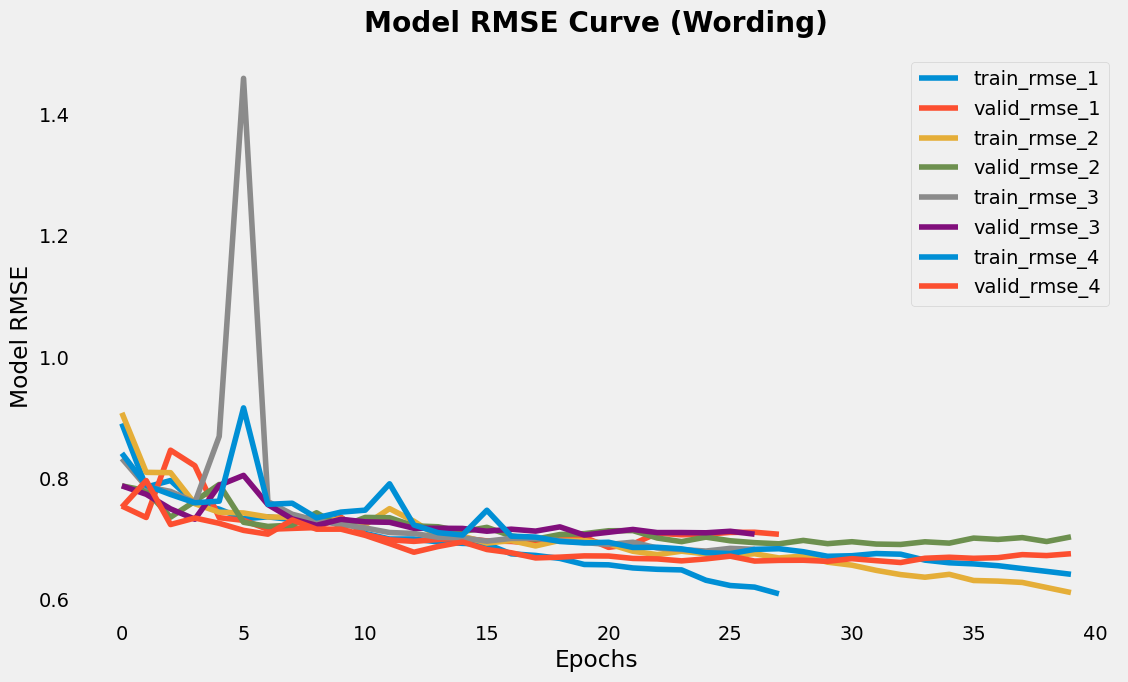

In [47]:
plt.figure(figsize=(12, 7))
plt.title("Model RMSE Curve (Wording)", fontweight='bold', pad=15)

for i in range(config.folds):
    plt.plot(loss_values["train_rmse_"+str(i+1)], label='train_rmse_'+str(i+1))
    plt.plot(loss_values["valid_rmse_"+str(i+1)], label='valid_rmse_'+str(i+1))

plt.ylabel('Model RMSE')
plt.xlabel('Epochs')
plt.legend()
plt.grid();

## Pseudo Labels

In [48]:
train['content_pred'] = train_preds_content
train['wording_pred'] = train_preds_wording
train.head()

,prompt_id,text,content,wording,summary_length,splling_err_num,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,...,subjectivity,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,text_clean,content_pred,wording_pred
0,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,-0.319463,-0.507499,-0.624726,-0.178868,-0.165914,-0.773761,...,-0.565728,-0.311755,-0.263633,0.307702,-0.040775,-0.059327,0.330000,the third wave was an experimentto see how peo...,0.054969,0.302114
1,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,-0.482817,-0.909174,1.591395,-0.712514,0.456644,-0.197961,...,1.265356,-0.647249,0.269136,-0.553465,-0.876099,-0.059327,-0.584326,they would rub it up with soda to make the sme...,-0.770580,-0.669496
2,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,3.029279,3.107575,-0.811178,3.624452,1.079201,0.761707,...,0.256727,3.244487,2.932983,2.891202,1.838703,-0.059327,1.244325,in egypt there were many occupations and socia...,2.002194,1.554679
3,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,-0.907535,-0.507499,-0.811178,-0.773949,-1.411029,-0.709783,...,-2.413533,-0.714348,-1.062788,-0.744835,-0.667268,-0.059327,0.330000,the highest class was pharaohs these people we...,-1.261874,-0.656716
4,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,2.424872,2.705900,-0.624726,2.724641,1.234840,-0.038016,...,-0.453263,2.707696,1.867444,2.221405,0.168056,-0.059327,4.901629,the third wave developed rapidly because the ...,2.065967,2.371746


In [49]:
test['content_pred'] = np.mean(test_preds_content, axis=0)
test['wording_pred'] = np.mean(test_preds_wording, axis=0)
test.head()

,prompt_id,text,summary_length,splling_err_num,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,bigram_overlap_ratio,trigram_overlap_count,...,subjectivity,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,text_clean,content_pred,wording_pred
0,abc123,Example text 1,-1.315918,-1.176957,-4.124705,10.121676,-2.344865,-0.901717,-1.510086,-0.648154,...,-2.413533,-1.116942,-1.062788,-1.318947,-1.293761,-0.059327,0.33,example text 1,-1.802261,-1.833781
1,def789,Example text 2,-1.315918,-1.176957,-4.124705,10.121676,-2.344865,-0.901717,-1.510086,-0.648154,...,-2.413533,-1.116942,-1.062788,-1.318947,-1.293761,-0.059327,0.33,example text 2,-1.805238,-1.826531
2,abc123,Example text 3,-1.315918,-1.176957,-4.124705,10.121676,-2.344865,-0.901717,-1.510086,-0.648154,...,-2.413533,-1.116942,-1.062788,-1.318947,-1.293761,-0.059327,0.33,example text 3,-1.804023,-1.809931
3,def789,Example text 4,-1.315918,-1.176957,-4.124705,10.121676,-2.344865,-0.901717,-1.510086,-0.648154,...,-2.413533,-1.116942,-1.062788,-1.318947,-1.293761,-0.059327,0.33,example text 4,-1.802860,-1.804470


In [50]:
del train_preds_content, train_preds_wording
del test_preds_content, test_preds_wording
gc.collect()

61482

## LightGBM Model

In [51]:
features = [
    'summary_length',
    'splling_err_num',
    'prompt_length',
    'length_ratio',
    'word_overlap_count',
    'bigram_overlap_count',
    'bigram_overlap_ratio',
    'trigram_overlap_count',
    'trigram_overlap_ratio',
    'quotes_count',
    "num_words",
    "num_unique_words",
    "num_chars",
    "num_stopwords",
    "num_punctuations",
    "num_words_upper",
    "num_words_title",
    "mean_word_len",
    "num_paragraphs",
    "num_sentences",
    "polarity",
    "subjectivity",
    'nn_count',
    'pr_count',
    'vb_count',
    'jj_count',
    'uh_count',
    'cd_count',
    'content_pred',
    'wording_pred'
]

targets = ["content", "wording"]

In [52]:
rmses = []
pred_dict = {}

for target in targets:
    trues = []
    train_preds = []
    test_preds = []
    
    gkf = GroupKFold(n_splits=config.folds)
    
    for fold, (train_idx, val_idx) in enumerate(gkf.split(train, groups=train["prompt_id"])):

        X_train_cv = train.iloc[train_idx][features]
        y_train_cv = train.iloc[train_idx][target]

        X_eval_cv = train.iloc[val_idx][features]
        y_eval_cv = train.iloc[val_idx][target]

        dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
        dval = lgb.Dataset(X_eval_cv, label=y_eval_cv)

        params = {
            'boosting_type': 'gbdt',
            'random_state': 42,
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.05,
        }

        evaluation_results = {}
        
        model = lgb.train(
            params,
            num_boost_round=10000,
            valid_names=['train', 'valid'],
            train_set=dtrain,
            valid_sets=dval,
            callbacks=[
                lgb.early_stopping(stopping_rounds=30, verbose=True),
                lgb.log_evaluation(100),
                lgb.callback.record_evaluation(evaluation_results)
            ],
        )
        
        pred = model.predict(X_eval_cv)

        trues.extend(y_eval_cv)
        train_preds.extend(pred)
        
        pred = model.predict(test[features])
        test_preds.append(pred)
        
        del X_train_cv, y_train_cv
        del X_eval_cv, y_eval_cv
        del dtrain, dval, pred
        del model, evaluation_results
        gc.collect()
    
    
    rmse = np.sqrt(mean_squared_error(trues, train_preds))
    print("\n=============================")
    print(f"{target}_rmse : {rmse}")
    print("=============================\n")
    rmses = rmses + [rmse]
    pred_dict[target] = test_preds

print(f"mcrmse : {sum(rmses) / len(rmses)}")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3895
[LightGBM] [Info] Number of data points in the train set: 5108, number of used features: 30
[LightGBM] [Info] Start training from score 0.017606
Training until validation scores don't improve for 30 rounds
[100]	train's rmse: 0.40056
Early stopping, best iteration is:
[81]	train's rmse: 0.400071
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3769
[LightGBM] [Info] Number of data points in the train set: 5156, number of used features: 28
[LightGBM] [Info] Start training from score -0.039959
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	train's rmse: 0.50916
[LightGBM] [Warning] Auto-choosing c

In [53]:
y_pred_content = np.mean(pred_dict.get('content'), axis=0)
y_pred_wording = np.mean(pred_dict.get('wording'), axis=0)
print(f"y_pred_content: {y_pred_content.shape} \ny_pred_wording: {y_pred_wording.shape}")

y_pred_content: (4,) 
y_pred_wording: (4,)


## Create submission file

In [54]:
sub = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv")
print(f"sub: {sub.shape}")
sub.head()

sub: (4, 3)


,student_id,content,wording
0,000000ffffff,0.0,0.0
1,111111eeeeee,0.0,0.0
2,222222cccccc,0.0,0.0
3,333333dddddd,0.0,0.0


In [55]:
sub['content'] = y_pred_content
sub['wording'] = y_pred_wording
sub.head()

,student_id,content,wording
0,000000ffffff,-1.285752,-1.140641
1,111111eeeeee,-1.285752,-1.140641
2,222222cccccc,-1.285752,-1.140641
3,333333dddddd,-1.285752,-1.140641


In [56]:
sub.to_csv("./submission.csv", index=False)

In [57]:
## Good Day!!